In [15]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [16]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [17]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [18]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [19]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [20]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [21]:
scaling = build_dataframe(x_axis='mpi', factor=20)
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
12    4     8       32      1         1        1        6840.0   
6     8     8       64      2         1        1        3840.0   
8    12     8       96      3         1        1        2767.0   
9    16     8      128      4         1        1        2168.0   
5    20     8      160      5         1        1        1763.0   
1    40     8      320     10         1        1        1019.0   
2    60     8      480     15         1        1         721.0   
7    80     8      640     20         1        1         542.0   
3   100     8      800     25         1        1         446.0   
10  120     8      960     30         1        1         405.0   
11  140     8     1120     35         1        1         354.0   
0   160     8     1280     40         1        1         316.0   
4   200     8     1600     50         1        1         267.0   

    io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...  DIPOLE_transverse         Xo  \
12            0.0000        0.0000  0.0001  ...          2922.0000  3020.0000   
6             0.0000        0.0001  0.0001  ...          1476.0000  1932.0000   
8             0.0001        0.0001  0.0001  ...           995.0000  1402.0000   
9             0.0000        0.0001  0.0001  ...           741.0000  1136.0000   
5             0.0000        0.0001  0.0001  ...           597.1288   938.0000   
1             0.0001        0.0001  0.0001  ...           310.5541   552.2515   
2             0.0001        0.0001  0.0001  ...           211.1586   387.6636   
7             0.0001        0.0001  0.0002  ...           161.0821   301.9688   
3             0.0001        0.0001  0.0001  ...           132.1271   235.7383   
10            0.0001        0.0001  0.0002  ...           114.7679   217.8780   
11            0.0001        0.0002  0.0001  ...            98.1385   182.5872   
0             0.0001        0.0001  0.0002  ...            88.0622   159.8472   
4             0.0001        0.0001  0.0002  ...            74.2974   137.8192   

      Dipoles  gpu  ideal   speedup  efficiency  Self energy    Other  \
12  2924.0000    4    0.2  0.257749  128.874269     885.0438   4.5711   
6   1479.0000    8    0.4  0.459115  114.778646     451.6268 -29.3156   
8    999.0000   12    0.6  0.637152  106.192025     334.6533  23.8587   
9    743.0000   16    0.8  0.813192  101.648985     257.0648  24.7090   
5    600.0000   20    1.0  1.000000  100.000000     195.7894  27.0048   
1    314.6036   40    2.0  1.730128   86.506379     124.6729  25.0666   
2    217.8861   60    3.0  2.445215   81.507166      78.5183  29.7287   
7    165.0172   80    4.0  3.252768   81.319188      51.5035  21.1726   
3    137.5690  100    5.0  3.952915   79.058296      45.1188  25.2537   
10   123.2480  120    6.0  4.353086   72.551440      34.0016  27.5113   
11   106.4343  140    7.0  4.980226   71.146086      33.1455  29.4870   
0     95.4596  160    8.0  5.579114   69.738924      28.4254  29.8322   
4     81.1682  200   10.0  6.602996   66.029963      22.6336  22.9949   

      node_h  
12  1.900000  
6   2.133333  
8   2.305833  
9   2.408889  
5   2.448611  
1   2.830556  
2   3.004167  
7   3.011111  
3   3.097222  
10  3.375000  
11  3.441667  
0   3.511111  
4   3.708333  

[13 rows x 52 columns]

In [22]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile    Dipoles         Xo       X  Self energy    Other
12    4        6840.0  2924.0000  3020.0000  6.3851     885.0438   4.5711
6     8        3840.0  1479.0000  1932.0000  6.6888     451.6268 -29.3156
8    12        2767.0   999.0000  1402.0000  7.4880     334.6533  23.8587
9    16        2168.0   743.0000  1136.0000  7.2262     257.0648  24.7090
5    20        1763.0   600.0000   938.0000  2.2058     195.7894  27.0048
1    40        1019.0   314.6036   552.2515  2.4054     124.6729  25.0666
2    60         721.0   217.8861   387.6636  7.2033      78.5183  29.7287
7    80         542.0   165.0172   301.9688  2.3379      51.5035  21.1726
3   100         446.0   137.5690   235.7383  2.3202      45.1188  25.2537
10  120         405.0   123.2480   217.8780  2.3611      34.0016  27.5113
11  140         354.0   106.4343   182.5872  2.3460      33.1455  29.4870
0   160         316.0    95.4596   159.8472  2.4356      28.4254  29.8322
4   200         267.0    81.1682   137.8192  2.3841      22.6336  22.9949

In [14]:
scaling[['mpi', 'nodes', 'Time-Profile', 'efficiency', 'node_h']].to_csv('rutile_benchmark.csv', sep='\t')

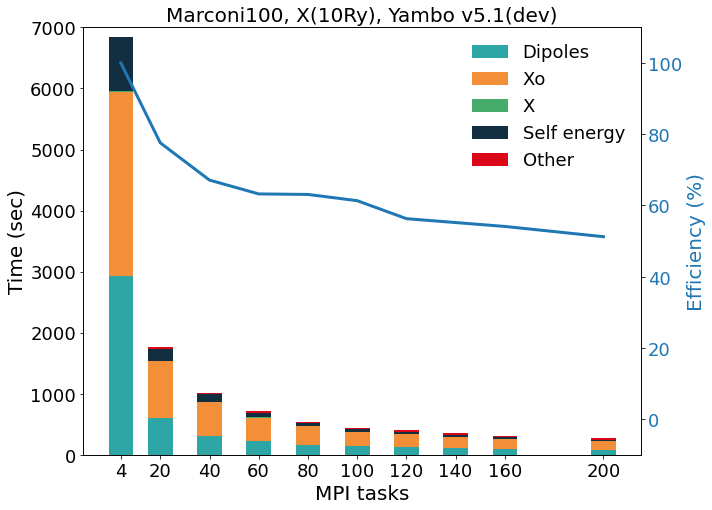

In [15]:
build_scaling_plot(scaling=scaling[(scaling['mpi']==4) | (scaling['mpi']>=20)], 
                   pile=pile, colors=colors, bar_width=10, efficiency=True,
                   legend_loc='upper right', title=r'Marconi100, X(10Ry), Yambo v5.1(dev)', 
                   file_name='scaling_1nodes.png', y_lim=[0,7000])

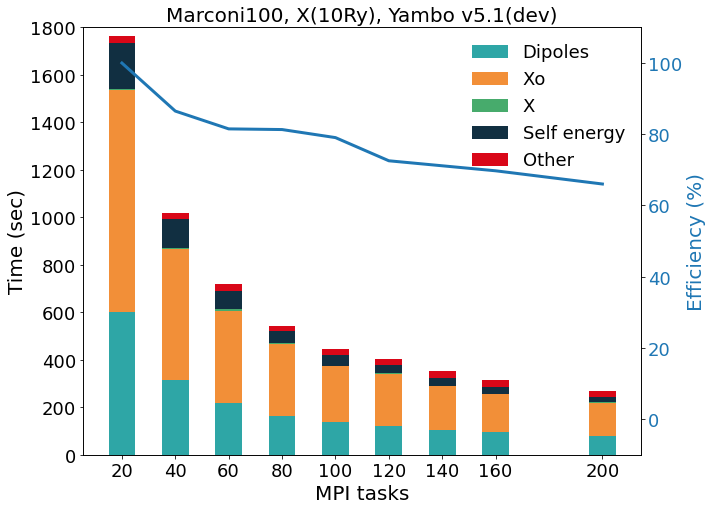

In [13]:
build_scaling_plot(scaling=scaling[scaling['mpi']>=20], 
                   pile=pile, colors=colors, bar_width=10, efficiency=True,
                   legend_loc='upper right', title=r'Marconi100, X(10Ry), Yambo v5.1(dev)', 
                   file_name='scaling_5nodes.png', y_lim=[0,1800])

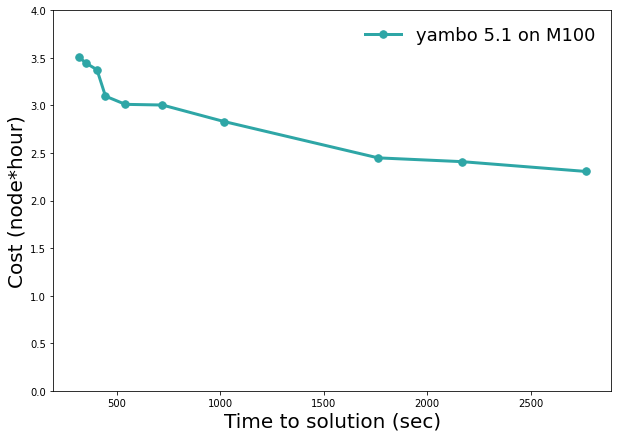

In [21]:
build_cost_plot(scaling=scaling, label='yambo 5.1 on M100', y_lim=[0,4.0])

In [9]:
io_cols=['mpi', 'io_ATMPROJ_pwscf', 'io_KB_abinit', 'io_BS', 'io_Double_Grid', 'io_COL_CUT', 'PP_uspp_init', 'io_HF', 'IO_and_Messaging_switch', 'io_QINDX', 'io_KB_pwscf', 'io_DIPOLES', 'io_fragment', 'io_WF']
scaling[scaling['mpi']>=20][io_cols]

mpi  io_ATMPROJ_pwscf  io_KB_abinit   io_BS  io_Double_Grid  io_COL_CUT  \
5    20            0.0000        0.0001  0.0001          0.0002      0.0003   
1    40            0.0001        0.0001  0.0001          0.0002      0.0003   
2    60            0.0001        0.0001  0.0001          0.0002      0.0009   
7    80            0.0001        0.0001  0.0002          0.0003      0.0004   
3   100            0.0001        0.0001  0.0001          0.0021      0.0003   
10  120            0.0001        0.0001  0.0002          0.0002      0.0004   
11  140            0.0001        0.0002  0.0001          0.0003      0.0398   
0   160            0.0001        0.0001  0.0002          0.0003      0.0115   
4   200            0.0001        0.0001  0.0002          0.0007      0.0004   

    PP_uspp_init   io_HF  IO_and_Messaging_switch  io_QINDX  io_KB_pwscf  \
5         0.0006  0.0155                   0.0006    0.0147       0.1681   
1         0.0007  0.0139                   0.0006    0.0062       0.2271   
2         0.0007  0.0141                   0.0006    0.0140       0.5460   
7         0.0006  0.0140                   0.0006    0.0137       0.2270   
3         0.0006  0.0134                   0.0006    0.0071       0.2649   
10        0.0006  0.0139                   0.0006    0.0232       0.1931   
11        0.0007  0.0158                   0.0006    0.0460       0.1646   
0         0.0007  0.0145                   0.0006    0.0141       0.1934   
4         0.0007  0.0224                   0.0006    0.0233       0.3546   

    io_DIPOLES  io_fragment   io_WF  
5       1.4498       1.5054  9.8024  
1       1.3195       1.5931  6.0979  
2       1.6154       2.5676  8.0957  
7       1.4089       1.3983  3.9492  
3       1.4399       1.8485  4.0050  
10      1.2994       1.2904  3.1190  
11      1.5390       1.9950  3.5678  
0       1.4429       1.4400  2.8723  
4       1.5189       2.2204  3.7778

In [4]:
parse_report('r-rutile_50nodes.out_HF_and_locXC_gw0_rim_cut_em1d_ppa')

({'mpi': 200,
  'thrs': 8,
  'thr_tot': 1600,
  'nodes': 50,
  'nodes_io': 1,
  'mpi/gpu': 1},
 {'Time-Profile': 267.0,
  'io_ATMPROJ_pwscf': 0.0001,
  'io_KB_abinit': 0.0001,
  'io_BS': 0.0002,
  'io_Double_Grid': 0.0007,
  'io_COL_CUT': 0.0004,
  'PP_uspp_init': 0.0007,
  'io_HF': 0.0224,
  'IO_and_Messaging_switch': 0.0006,
  'GW(REDUX)': 2.2952,
  'HF(REDUX)': 0.4926,
  'io_QINDX': 0.0233,
  'scatter_Gamp_gpu': 0.0065,
  'io_QP_and_GF': 0.0216,
  'io_GROT': 0.0775,
  'io_KB_pwscf': 0.3546,
  'io_X': 1.2448,
  'FFT_setup': 0.1836,
  'SERIAL_lin_system_gpu': 0.4529,
  'LINEAR ALGEBRA': 0.4531,
  'MATRIX transfer (X_G_finite_q_X_redux_1_2)': 0.542,
  'MATRIX transfer (X_G_finite_q_X_redux_1_1)': 0.5406,
  'MATRIX transfer (X_G_finite_q_X_redux_2_1)': 0.5432,
  'MATRIX transfer (X_G_finite_q_X_redux_2_2)': 0.5268,
  'RIM': 0.7142,
  'io_fragment': 2.2204,
  'io_DIPOLES': 1.5189,
  'X (REDUX)': 2.2422,
  'X (procedure)': 2.3841,
  'io_WF': 3.7778,
  'HF': 2.3449,
  'WF_load_FFT': 4.4302

In [5]:
resources_old, timing_old = ({'mpi': 200,
  'thrs': 8,
  'thr_tot': 1600,
  'nodes': 50,
  'nodes_io': 1,
  'mpi/gpu': 4},
 {'Time-Profile': 314.0,
  'io_ATMPROJ_pwscf': 0.0001,
  'io_KB_abinit': 0.0001,
  'io_BS': 0.0001,
  'io_Double_Grid': 0.0002,
  'io_COL_CUT': 0.0201,
  'io_HF': 0.0256,
  'PP_uspp_init': 0.0007,
  'IO_and_Messaging_switch': 0.0005,
  'HF(REDUX)': 0.6496,
  'GW(REDUX)': 1.114,
  'io_QINDX': 0.0078,
  'scatter_Gamp_gpu': 0.0086,
  'io_GROT': 0.066,
  'io_QP_and_GF': 0.0481,
  'io_DIPOLES': 1.3884,
  'io_KB_pwscf': 0.4562,
  'FFT_setup': 0.2099,
  'io_fragment': 1.1341,
  'io_X': 1.0724,
  'MATRIX transfer (X_G_finite_q_X_redux_1_1)': 0.5243,
  'MATRIX transfer (X_G_finite_q_X_redux_1_2)': 0.5158,
  'MATRIX transfer (X_G_finite_q_X_redux_2_2)': 0.5164,
  'MATRIX transfer (X_G_finite_q_X_redux_2_1)': 0.5265,
  'RIM': 1.0641,
  'SERIAL_lin_system_gpu': 1.1385,
  'LINEAR ALGEBRA': 1.1387,
  'X (REDUX)': 2.8891,
  'X (procedure)': 3.0831,
  'io_WF': 3.2734,
  'HF': 2.6406,
  'WF_load_FFT': 4.0521,
  'Xo (REDUX)': 63.6865,
  'XC_potential_driver': 5.3225,
  'XCo_local': 5.3241,
  'GW(ppa)': 17.5087,
  'DIPOLE_transverse': 75.9443,
  'Xo (procedure)': 139.773,
  'Dipoles': 85.7031})

In [6]:
resources_new, timing_new = parse_report('r-rutile_50nodes.out_HF_and_locXC_gw0_rim_cut_em1d_ppa')

In [7]:
for key in timing_new:
    print('{}: {}'.format(key, float(timing_old[key])-float(timing_new[key])))

Time-Profile: 47.0
io_ATMPROJ_pwscf: 0.0
io_KB_abinit: 0.0
io_BS: -0.0001
io_Double_Grid: -0.0005
io_COL_CUT: 0.0197
PP_uspp_init: 0.0
io_HF: 0.0032000000000000015
IO_and_Messaging_switch: -9.999999999999994e-05
GW(REDUX): -1.1811999999999998
HF(REDUX): 0.15699999999999997
io_QINDX: -0.015500000000000002
scatter_Gamp_gpu: 0.0021000000000000003
io_QP_and_GF: 0.026499999999999996
io_GROT: -0.011499999999999996
io_KB_pwscf: 0.10159999999999997
io_X: -0.1723999999999999
FFT_setup: 0.02629999999999999
SERIAL_lin_system_gpu: 0.6856
LINEAR ALGEBRA: 0.6856
MATRIX transfer (X_G_finite_q_X_redux_1_2): -0.0262
MATRIX transfer (X_G_finite_q_X_redux_1_1): -0.01629999999999998
MATRIX transfer (X_G_finite_q_X_redux_2_1): -0.016700000000000048
MATRIX transfer (X_G_finite_q_X_redux_2_2): -0.010400000000000076
RIM: 0.3499000000000001
io_fragment: -1.0863
io_DIPOLES: -0.13049999999999984
X (REDUX): 0.6469
X (procedure): 0.6989999999999998
io_WF: -0.5044
HF: 0.2957000000000001
WF_load_FFT: -0.378099999999

In [9]:
the_sum=0.0
for val in timing_new.values():
    the_sum += float(val)
the_sum

678.8317999999999

In [23]:
scaling[['mpi', 'nodes', 'Time-Profile'] + pile].to_latex('strong_scaling.tex', index=False)